In [28]:
import pyupbit
class My_Upbit(pyupbit.Upbit):
    
    def __init__(self,access_key,secret_key,coinid='ZRX'):
        super().__init__(access_key,secret_key)
        
        self.coin_info = self.select_my_coin(coinid)
        self.coinid = coinid
        
    def select_my_coin(self,coinid):
        
        coins = self.get_balances()
        
        coin_index = 0
        my_coin = ''
        for idx,coin in enumerate(coins):
            if coin['currency'] == coinid:
                coin_index = idx
                my_coin = coin
        return my_coin

In [48]:
import pyupbit
import pandas as pd
import time
import numpy as np

class My_Upbit_Data():
    
    def __init__(self,coinid='ZRX'):
        
        self.coinid = coinid

    def __load_data(self, interval='minute10', date=None, rows=1000):
        dfs = []
        
        ranges = int(rows/200)
        
        for i in range(ranges):
            df = pyupbit.get_ohlcv(ticker='KRW-'+self.coinid, interval=interval, to=date)
            dfs.append(df)

            date = df.index[0]
            time.sleep(0.15)

        df = pd.concat(dfs).sort_index()
        
        return df
    
    def load_ml_data(self,col='open',interval='minute10',rows=20000):
        dataframe = self.__load_data(interval=interval, rows=rows)
        times = dataframe.index

        return [times,dataframe]

In [87]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

class My_Lstm:
  def windowed_dataset(self,series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    
    return ds.batch(batch_size).prefetch(1)
  
  def __dataframe_to_series(self,dataframe,col='open'):
    data = dataframe

    return np.asarray(data[col],dtype='float32')
  
  def scale_data_fit(self,series):
    self.min_scale = np.min(series)
    self.max_scale = np.max(series)
  
  def scale_data(self,series):
    series = np.array(series)
    series -= self.min_scale
    series /= self.max_scale
    
    return series
  
  def un_scale_data(self,series):
    series = np.array(series)
    series *= self.max_scale
    series += self.min_scale
    
    return series
  
  def keras_layers_compile(self, loss='mae', optimizer='adam', metrics='mae'):
    self.model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,input_shape=[None,1],return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)])
    
    self.model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
  
  def callbacks(self,monitor='loss',mode='min',patience=10):
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 10))
    earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'loss',mode='min',patience=10)
    return [lr_schedule,earlystop]
      
  def fit_lstm(self,dataset,epochs=100,callbacks=None):
    if callbacks:
        history = self.model.fit(dataset,epochs=epochs,callbacks=callbacks)
    else:
        history = self.model.fit(dataset,epochs=epochs)
    return history
          
  def traing_lstm(self,dataframe,scale=False,col='open',epochs=100,callbacks=None,loss='mae', optimizer='adam', metrics='mae', window_size=7, batch_size=16, shuffle_buffer=30000):
    self.scale = scale
    
    # Dataframe to series 하나의 컬럼만 가져와서 예측진행
    series = self.__dataframe_to_series(dataframe,col=col)

    # 원본데이터 백업
    self.backup_series = series

    # Scale 진행 MinMax scale
    if self.scale:
        self.scale_data_fit(series)
        series = self.scale_data(series)
    else:
        pass

    # Tensorflow 전용 데이터셋으로 변환 (window size=예측할 날짜수)
    self.window_size = window_size
    series = self.windowed_dataset(series,self.window_size,batch_size,shuffle_buffer)

    # Keras
    self.keras_layers_compile(loss=loss, optimizer=optimizer, metrics=metrics)
    if callbacks:
        callbacks = self.callbacks()
    else:

      pass
    history = self.fit_lstm(series,epochs=epochs,callbacks=callbacks)
    
    return history
  
  def save_md(self,name):
      try:
        self.model.save(name)
      except:
        print('Error!')
          
  def model_load(self,name):
      self.keras_layers_compile()
      self.model = tf.keras.models.load_model(name)
  
  def predict(self,times,ranges=[0,200]):
      predicts = []
      self.ranges = ranges
      # self.backup_series_to_un_scale = self.un_scale_data(self.backup_series[ranges[0]:ranges[1]])

      self.time_series = times[ranges[0]:ranges[1]]

      ranges_series = self.backup_series[ranges[0]:ranges[1]]

      
      if self.scale:

        ranges_series_scale = self.scale_data(ranges_series)

        for time in range(len(ranges_series_scale)-self.window_size):

            pred = np.array(ranges_series_scale[time : time + self.window_size])

            pred = pred.reshape(1,-1,1)


            predict = self.model.predict(pred)

            predicts.append(predict[0][0])
        # 수정부분
        predicts = self.un_scale_data(predicts)
      else:

        for time in range(len(ranges_series)-self.window_size):
            pred = np.array(ranges_series[time : time + self.window_size])

            pred = pred.reshape(1,-1,1)

            predict = self.model.predict(pred)

            predicts.append(predict[0][0])
    
      return predicts
          
  def predict_plot(self,predicts):
      
      plt.figure(figsize=(12,8))
      plt.plot(self.time_series[:-self.window_size],predicts,color='red',label='Predict')
      plt.plot(self.time_series[:-self.window_size],self.backup_series[self.ranges[0]:self.ranges[1]-self.window_size],color='blue',label='Real')
      plt.legend(loc='center left')
      plt.show()
      
  def predict_last_few_days(self,future_days,last_future_series):

    self.future_days = future_days

    futures = []
    _last_future_series = last_future_series
    if self.scale:

      _last_future_series = self.scale_data(_last_future_series)
      for time in range(future_days):
          pred = np.array(_last_future_series,dtype='float64')

          pred = pred.reshape(1,-1,1)

          predict = self.model.predict(pred)

          _last_future_series.append(predict[0][0])

          futures.append(predict[0][0])

          _last_future_series.pop(0)
      futures = self.un_scale_data(futures)

    else:
      for time in range(future_days):
          pred = np.array(_last_future_series,dtype='float64')

          pred = pred.reshape(1,-1,1)

          predict = self.model.predict(pred)

          _last_future_series.append(predict[0][0])
          futures.append(predict[0][0])

          _last_future_series.pop(0)

    self.futures = futures

  def plot_few_days(self):

    plt.plot(np.arange(self.future_days),self.futures)
    plt.title('{}days'.format(self.future_days))
    plt.show()

In [44]:
access_key = 'ych2HyuGShHt6QLKVQAyJdXDuED18BtFKNffxyOC'
secret_key = 'zaeD3LvD3TXxMQZgrmvInpD3dqZ6slPa0uC92xSq'
My_Upbit = My_Upbit(access_key,secret_key)

In [84]:
mylstm = My_Lstm()

In [52]:
mud = My_Upbit_Data(coinid='ZRX')

In [53]:
times, data = mud.load_ml_data(col='open', interval='minute10', rows=20000)

In [54]:
data.shape

(20000, 5)

In [ ]:
tf.keras.losses.MeanSquaredLogarithmicError()


In [86]:
history = mylstm.traing_lstm(dataframe=data,scale=False,col='open',epochs=50,loss='mse',metrics=tf.keras.metrics.RootMeanSquaredError(),callbacks='go')

Epoch 1/50
1250/1250 [==============================] - 54s 43ms/step - loss: 1465037.1250 - root_mean_squared_error: 1210.3873
Epoch 2/50
1250/1250 [==============================] - 50s 40ms/step - loss: 1464911.2500 - root_mean_squared_error: 1210.3352
Epoch 3/50
1250/1250 [==============================] - 53s 43ms/step - loss: 1464755.5000 - root_mean_squared_error: 1210.2708
Epoch 4/50
1250/1250 [==============================] - 52s 41ms/step - loss: 1464562.1250 - root_mean_squared_error: 1210.1909
Epoch 5/50
1250/1250 [==============================] - 50s 40ms/step - loss: 1464322.0000 - root_mean_squared_error: 1210.0917
Epoch 6/50
1250/1250 [==============================] - 49s 39ms/step - loss: 1464029.1250 - root_mean_squared_error: 1209.9709
Epoch 7/50
1250/1250 [==============================] - 46s 37ms/step - loss: 1463674.2500 - root_mean_squared_error: 1209.8242
Epoch 8/50
1250/1250 [==============================] - 46s 37ms/step - loss: 1463234.7500 - root_mean_s

KeyboardInterrupt: 

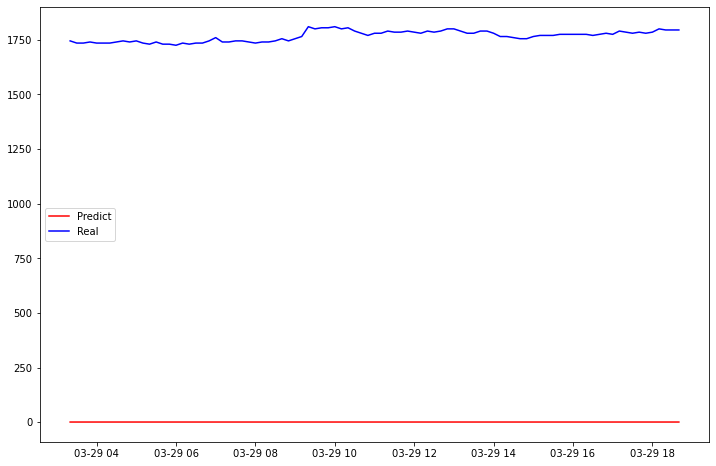

In [81]:
mylstm.predict_plot(times,ranges=[18900,19000])

In [75]:
mylstm.predicts

[0.11784725,
 0.12541342,
 0.12895615,
 0.13192919,
 0.13058476,
 0.12557355,
 0.1227055,
 0.12021798,
 0.1174678,
 0.11368622,
 0.109238155,
 0.10714552,
 0.10631496,
 0.10585116,
 0.107320085,
 0.11029033,
 0.11142108,
 0.109915264,
 0.10926521,
 0.108055204,
 0.10904223,
 0.111508414,
 0.11754465,
 0.12242849,
 0.12467687,
 0.123028114,
 0.120642215,
 0.11891709,
 0.12335086,
 0.12753232,
 0.13411762,
 0.13793468,
 0.13354471,
 0.12705247,
 0.11964418,
 0.11748855,
 0.11859489,
 0.11323936,
 0.11231412,
 0.11199817,
 0.108940706,
 0.107547656,
 0.108646885,
 0.112688586,
 0.11964029,
 0.12916653,
 0.13410957,
 0.14068142,
 0.14323723,
 0.14172496,
 0.1403155,
 0.14142294,
 0.14304993,
 0.14391477,
 0.14434485,
 0.14741546,
 0.1537352,
 0.15810917,
 0.16302274,
 0.16699527,
 0.1675087,
 0.16630973,
 0.1671534,
 0.16543226,
 0.16464461,
 0.16310428,
 0.16340993,
 0.16539204,
 0.16697161,
 0.16630416,
 0.16598855,
 0.16644518,
 0.16565976,
 0.16579218,
 0.16534555,
 0.16366622,
 0.1621

In [ ]:
tf.losses.msle

In [ ]:
tf.keras.metrics.RootMeanSquaredError

In [77]:
if False:
    print('aa')
else:
    print('zz')

zz


In [53]:
mylstm.save_md(name='ZRX_LSTM.h5')

In [58]:
mylstm.keras_layers_compile()
mylstm.model_load('ZRX_LSTM.h5')

In [56]:
mylstm.predict_last_few_days(7,mylstm.backup_series[:-7])

In [44]:
mylstm.backup_series[:-7]

array([0.01771654, 0.01771654, 0.01811024, ..., 0.76456696, 0.76259845,
       0.7606299 ], dtype=float32)

In [15]:
test = My_LSTM.backup_series[18000:19000]

In [16]:
window_size=7

In [21]:
def predict_plot(times,ranges=[0,200]):
    predicts = []
    ranges_series = My_LSTM.backup_series[ranges[0]:ranges[1]]

    for time in range(len(ranges_series)-window_size):
        pred = np.array(ranges_series[time : time + window_size])

        pred = My_LSTM.scale_data(pred)

        pred = pred.reshape(1,-1,1)

        predict = My_LSTM.model.predict(pred)

        predict = My_LSTM.un_scale_data(predict)

        predicts.append(predict[0][0])


    plt.figure(figsize=(12,8))
    plt.plot(times[ranges[0]:ranges[1]-window_size],predicts,color='red',label='Predict')
    plt.plot(times[ranges[0]:ranges[1]-window_size],ranges_series[:ranges[1]-window_size],color='blue',label='Real')
    plt.legend(loc='center left')
    plt.show()

In [24]:
ranges_series = My_LSTM.backup_series[18000:19000]

In [29]:
ranges_series[:19000-7].shape

(1000,)

993


ValueError: x and y must have same first dimension, but have shapes (993,) and (1000,)

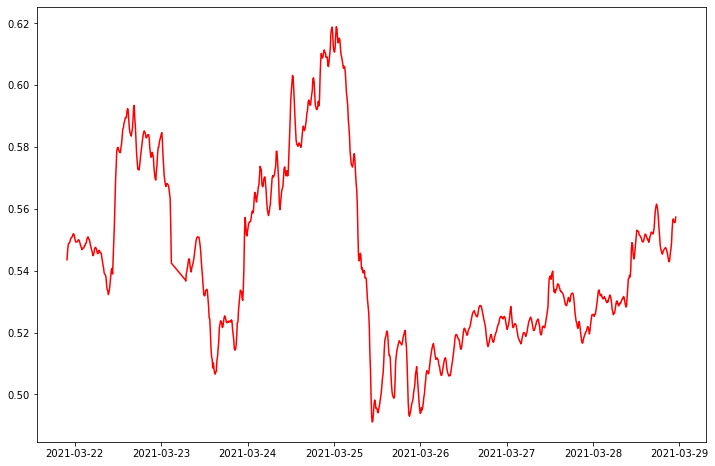

In [22]:
predict_plot(data[0],[18000,19000])

ValueError: x and y must have same first dimension, but have shapes (200,) and (193,)

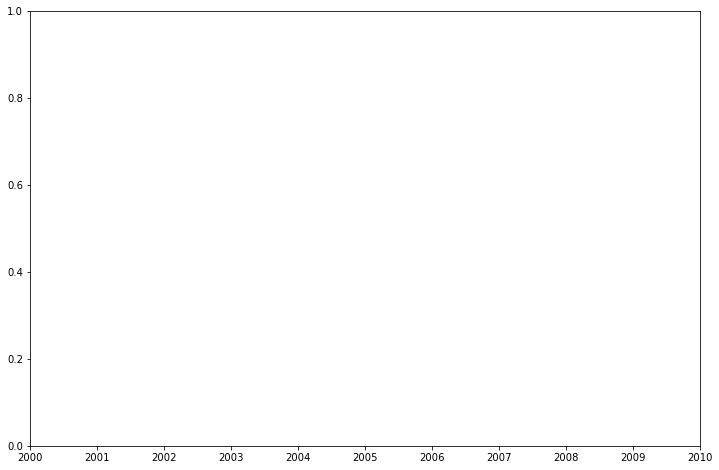

In [30]:
My_LSTM.predict_plot(data[0])

In [21]:
if None:
    print('aa')
else:
    print('tt')

tt


In [8]:
# 데이터를 Low를 하셔도 되고, 다른 데이터로 해도 무방합니다.
samsung_times = pd.to_datetime(samsung.Date,format='%Y-%m-%d')
samsung_series = samsung.Low
samsung_series_copy = samsung.Low

In [9]:
samsung_series = np.asarray(samsung_series,dtype='float32')

In [10]:
# normalization 진행
min_scale = np.min(samsung_series)
max_scale = np.max(samsung_series)
samsung_series -= min_scale
samsung_series /= max_scale

In [11]:
# Dataset 구성 함수
# 1차적으로 차원증가 후 텐서슬라이스에 매개변수로 전달
# 7일 + 1일 = 8일의 데이터 생성 (7일은 학습데이터, 1일은 정답데이터로 사용됨), drop_remainder 파라미터는 예측할 학습데이터가 7개가 안되면 삭제해서 진행
# flat_map을 이용해서 flat_map을 이용해서 8개로 생성
# shuffle을 이용해서 무작위로 섞음
# 마지막으로 7:1 (학습7,정답1)로 매핑진행
# 마지막으로 배치사이즈만큼 다시한번 매핑진행
# 참고사이트 : https://teddylee777.github.io/tensorflow/dataset-batch-window
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
# 학습용데이터로 전처리 진행
dataset = windowed_dataset(samsung_series, window_size, batch_size, shuffle_buffer)

In [13]:
# LSTM or GRU
# input_shape 는 [batch_size,1]만큼 들어갈 예정
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,input_shape=[None,1],return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512,'relu'),
    tf.keras.layers.Dense(256,'relu'),
    tf.keras.layers.Dense(128,'relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
# 시계열데이터라서 mse사용, optimizer는 adam으로 통일 metrics 또한 mse로 진행
model.compile(loss='mse',optimizer='adam',metrics=['mse'])

In [15]:
# learningrate 설정 진행, 점점 더 높아지게 설정
# earlystopping 설정, 과적합 방지
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'loss',mode='min',patience=10)

In [16]:
history = model.fit(dataset,epochs=150,callbacks=[lr_schedule,earlystop])

Epoch 1/150
165/165 [==============================] - 8s 51ms/step - loss: 0.3548 - mse: 0.3548
Epoch 2/150
165/165 [==============================] - 9s 53ms/step - loss: 0.3372 - mse: 0.3372
Epoch 3/150
165/165 [==============================] - 9s 57ms/step - loss: 0.3181 - mse: 0.3181
Epoch 4/150
165/165 [==============================] - 9s 53ms/step - loss: 0.2905 - mse: 0.2905: 2 - ETA: 0s - loss: 0.2906 - mse: 0.290
Epoch 5/150
165/165 [==============================] - 9s 52ms/step - loss: 0.2651 - mse: 0.2651
Epoch 6/150
165/165 [==============================] - 9s 52ms/step - loss: 0.2417 - mse: 0.2417
Epoch 7/150
165/165 [==============================] - 9s 53ms/step - loss: 0.2252 - mse: 0.2252
Epoch 8/150
165/165 [==============================] - 9s 53ms/step - loss: 0.2098 - mse: 0.2098
Epoch 9/150
165/165 [==============================] - 9s 53ms/step - loss: 0.1959 - mse: 0.1959: 0s - loss: 0.1964 -
Epoch 10/150
165/165 [==============================] - 9s 53ms/s

In [17]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("samsung.h5")

# It can be used to reconstruct the model identically.
samsung_model = tf.keras.models.load_model("samsung.h5")

In [18]:
# Window 사이즈 만큼 예측결과를 다시 Array로 반환
predicts = []
for time in range(len(samsung_series)-window_size):
    pred = np.array(samsung_series_copy[time : time + window_size])
    pred -= min_scale
    pred /= max_scale
    
    pred = pred.reshape(1,-1,1)
    
    predict = model.predict(pred)
    
    predict *= max_scale
    predict += min_scale
    
    predicts.append(predict[0][0])

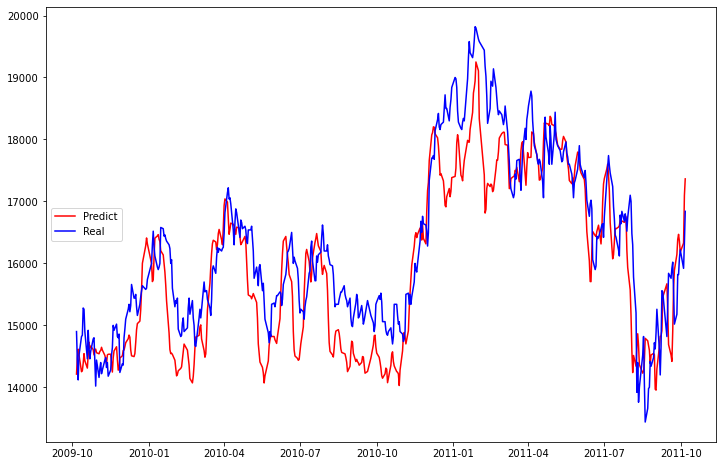

In [19]:
plt.figure(figsize=(12,8))
plt.plot(samsung_times[2500:3000],predicts[2500:3000],color='red',label='Predict')
plt.plot(samsung_times[2500:3000],samsung_series_copy[2500:3000],color='blue',label='Real')
plt.legend(loc='center left')
plt.show()

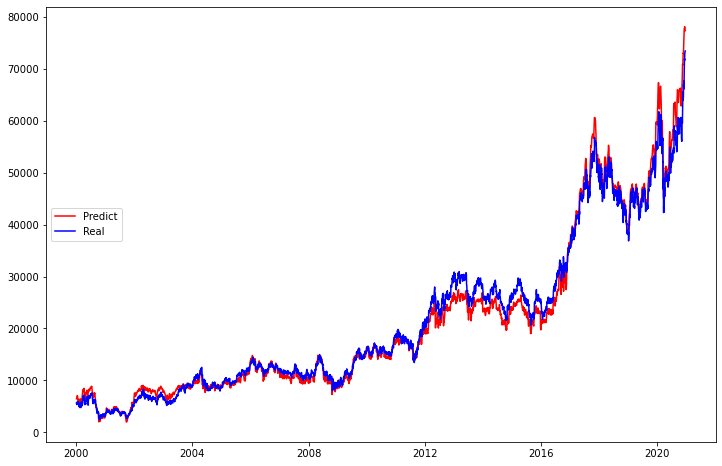

In [20]:
plt.figure(figsize=(12,8))
plt.plot(samsung_times[:len(samsung_series) - window_size],predicts[:len(samsung_series) - window_size],color='red',label='Predict')
plt.plot(samsung_times[:len(samsung_series) - window_size],samsung_series_copy[:len(samsung_series) - window_size],color='blue',label='Real')
plt.legend(loc='center left')
plt.show()

In [21]:
samsung_times[-7:]

5271   2020-12-17
5272   2020-12-18
5273   2020-12-21
5274   2020-12-22
5275   2020-12-23
5276   2020-12-24
5277   2020-12-28
Name: Date, dtype: datetime64[ns]

In [22]:
samsung_series_copy[-7:]

5271    72600.0
5272    73000.0
5273    72000.0
5274    72100.0
5275    72300.0
5276    74000.0
5277    78200.0
Name: Low, dtype: float64

In [23]:
# 7일까지만 예측진행
future_days = 7

future_series = predicts[-window_size:]

In [24]:
# 7일 예측씩 지속적으로 예측 진행
def predict_days(future_days,future_series):
    
    futures = []
    for time in range(future_days):
        pred = np.array(future_series,dtype='float64')
        pred -= min_scale
        pred /= max_scale

        pred = pred.reshape(1,-1,1)

        predict = model.predict(pred)

        predict *= max_scale
        predict += min_scale

        future_series.append(predict[0][0])
        futures.append(predict[0][0])

        future_series.pop(0)
        
    plt.plot(np.arange(future_days),futures)
    plt.title('{}days'.format(future_days))
    plt.show()

In [ ]:
predict_days(future_days,future_series)

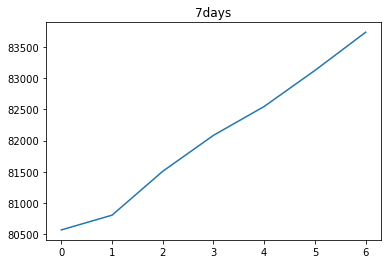

In [25]:
plt.plot(np.arange(future_days),futures)
plt.title('{}days'.format(future_days))
plt.show()

In [91]:
from sklearn.preprocessing import RobustScaler

In [92]:
robust = RobustScaler()

In [ ]:
robust.fit_transform()